We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep))

# get laplacian of magnetic field
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('classic')

import scipy.io as sio

from math import sqrt
from tqdm.notebook import tqdm

# import Rectangular bivariate spline from scipy
from scipy.interpolate import RectBivariateSpline as RBS

# Import package for parallel computing
from joblib import Parallel, delayed

from scipy.optimize import least_squares, newton, root
from scipy.integrate import solve_ivp

# Import fast scientific computing library
from numba import njit, prange

# import numpy
import numpy as np

In [2]:
# define parula map
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

cmapToUse = parula_map

# Import data

Import $ \overline{\omega_z}, \overline{j_z} $ computed over the time-interval $ [1, 3] $ and compute $ \boldsymbol{J} \nabla_0 \overline{j_z(\boldsymbol{x}_0)}, \boldsymbol{J} \nabla_0 \overline{\omega_z\left(\boldsymbol{x}_0\right)} $ using spectral derivatives.

In [3]:
directory_data = parent_directory+"/data/2D/LagrangianData/"

L = 2*np.pi
eta = 4*10**(-4)
nu = 4*10**(-4)

# load data
filename = directory_data+"matlab_files_FTLE_LAVD.mat"
mat_FTLE_LAVD = sio.loadmat(filename)
FTLE = mat_FTLE_LAVD["FTLE"]
LAVD = mat_FTLE_LAVD["LAVD"]
X, Y = mat_FTLE_LAVD["X"], mat_FTLE_LAVD["Y"]
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

filename = directory_data+"matlab_files_jz_wz.mat"
mat_jz_wz = sio.loadmat(filename)
jz_avg = mat_jz_wz["jz_avg"]
wz_avg = mat_jz_wz["wz_avg"]

filename = directory_data+"matlab_files_lap_b.mat"
mat_lap_b_avg = sio.loadmat(filename)
lap_b_avg = mat_lap_b_avg["lap_b_avg"]

filename = directory_data+"matlab_files_lap_vel.mat"
mat_lap_vel_avg = sio.loadmat(filename)
lap_vel_avg = mat_lap_vel_avg["lap_vel_avg"]


# Setup

In [4]:
# Number of cores for parallel computing
Ncores = 16 # int >= 1

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]
delta = [dx_data, dy_data]

# domain boundary
xmin = X.min() # between 0 and 2pi
xmax = X.max() # between 0 and 2pi
ymin = Y.min() # between 0 and 2pi
ymax = Y.max() # between 0 and 2pi

# Number of grid cells used in domain
Nx = X.shape[0]
Ny = Y.shape[1]

# ticks for plotting
xticks = [1, 2, 3, 4]
yticks = [3, 4, 5, 6]

# ticklabels for plotting
xticklabels = [r'$1$', r'$2$', r'$3$', r'$4$'] 
yticklabels = [r'$3$', r'$4$', r'$5$', r'$6$']

# specify domain over which to compute active magnetic barriers
x_domain = np.linspace(xmin, xmax, Nx, endpoint = True)
y_domain = np.linspace(ymin, ymax, Ny, endpoint = True)

# grid-spacing
dx = X[0,1]-X[0,0]
dy = Y[1,0]-Y[0,0]

#compute meshgrid
X_domain, Y_domain = X, Y

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy]

# Auxiliary functions
Here we define some auxiliar functions that we use for the computations. 

In [5]:
# Split x0, y0 into N (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

@njit()
def _find_all_local_maxima(X, Y, H, loc_threshold = 0, min_dist = 1*10**(-2)):
    '''
    Find all local maxima in a scalar field.

    Parameters:
        X: array (Nx, Ny), X-meshgrid
        Y: array (Nx, Ny), Y-meshgrid
        H: array(Nx, Ny), Scalar field to analyze
        
    Returns:
        idx_x: X position in the grid of the maxima 
        idx_y: Y position in the grid of the maxima
        loc_max_x: X position of the maxima (loc_max_x = X[idx_x, idx_y])
        loc_max_y: Y position of the maxima (loc_max_y = Y[idx_x, idx_y])
        loc_max_field: value of the maxima
    '''
    
    loc_max_x, loc_max_y, loc_max_field = [], [], []
    idx_x, idx_y = [], []
            
    for i in range(2, X.shape[0]-2):
                
        for j in range(2, Y.shape[1]-2):
                    
            if np.isfinite(H[i, j]) and H[i, j] > H[i+1, j] and H[i, j] > H[i-1, j] and H[i, j] > H[i, j+1] and H[i, j] > H[i, j-1] and H[i,j] > loc_threshold:
                
                bool_add = True
                
                for k in range(len(loc_max_x)):
                    if sqrt((X[i, j]-loc_max_x[k])**2+(Y[i, j]-loc_max_y[k])**2) < min_dist:
                        bool_add = False
                
                if bool_add:
                
                    loc_max_x.append(X[i, j])
                    loc_max_y.append(Y[i, j])
                    loc_max_field.append(H[i, j])
                    idx_x.append(j)
                    idx_y.append(i)
    
    return idx_x, idx_y, loc_max_x, loc_max_y, loc_max_field

def velocity(x, Interpolant_x, Interpolant_y):
    
    vx = Interpolant_x(x[1]%(2*np.pi), x[0]%(2*np.pi))[0][0]
    vy = Interpolant_y(x[1]%(2*np.pi), x[0]%(2*np.pi))[0][0]
    
    return [vx, vy]

def velocity_odeint(t, x, Interpolant_x, Interpolant_y):
    
    vx = Interpolant_x(x[1]%(2*np.pi), x[0]%(2*np.pi))[0][0]
    vy = Interpolant_y(x[1]%(2*np.pi), x[0]%(2*np.pi))[0][0]
    
    v_norm = sqrt(vx**2+vy**2)
    
    return [vx/v_norm, vy/v_norm]

def sort_algorithm(arg_sort, list_):

    sorted_list = []
    
    for a in arg_sort:
        sorted_list.append(list_[a])

    return sorted_list

def get_ABS(x, Interpolant_x, Interpolant_y):
    
    v = velocity(x, Interpolant_x, Interpolant_y)
    
    return np.sqrt(v[0]**2+v[1]**2)
    
def grad_ABS(x, Interpolant_x, Interpolant_y):
    
    xr = x+10**(-6)*np.array([1,0])
    xl = x-10**(-6)*np.array([1,0])
    
    xu = x+10**(-6)*np.array([0,1])
    xd = x-10**(-6)*np.array([0,1])
    
    ABSr = get_ABS(xr, Interpolant_x, Interpolant_y)
    ABSl = get_ABS(xl, Interpolant_x, Interpolant_y)
    ABSu = get_ABS(xu, Interpolant_x, Interpolant_y)
    ABSd = get_ABS(xd, Interpolant_x, Interpolant_y)
    
    dABSdx = (ABSr-ABSl)/(xr[0]-xl[0])
    dABSdy = (ABSu-ABSd)/(xu[1]-xd[1])
    
    return [dABSdx, dABSdy]
      
def get_all_barriers(X, Y, ABS, ABS_threshold, Interpolant_x, Interpolant_y, NT, Lmin, Tmax, min_dist):
    
    epsilon_ABS = ABS_threshold
    
    def get_barrier_ABS(ic, Lmin, Tmax, Interpolant_x, Interpolant_y, epsilon_ABS, NT = 500):
    
        class Solution:
            def __init__(self, y):
                self.y = y
    
                ABS_init = get_ABS(ic, Interpolant_x, Interpolant_y)
    
        def stopping_criterion(t, x, Interpolant_x, Interpolant_y):
        
            ABS = get_ABS(x, Interpolant_x, Interpolant_y)
        
            return epsilon_ABS-ABS
    
        def get_length(x, Lmin):
        
            x_init = x[0,0]
            y_init = x[1,0]
        
            L = 0
        
            final_index = -1
            epsilon = 1*10**(-2)
        
            bool_add = True
        
            index = -1
        
            for i in range(x.shape[1]-1):
                L += sqrt((x[0,i+1]-x[0,i])**2+(x[1,i+1]-x[1,i])**2)
                if (L > 0.1) and (sqrt((x[0,i+1]-x_init)**2+(x[1,i+1]-y_init)**2) < epsilon):
                    index = i
                    break
                   
            return L, index
    
        # compute initial guess for manifold
        advected = []
    
        stopping_criterion.terminal = True
        stopping_criterion.direction = 1
    
        sol = solve_ivp(velocity_odeint, [0, Tmax], ic, t_eval = np.linspace(0, Tmax, NT),
                    rtol=1e-8, atol = 1e-8, method = 'RK45', events = stopping_criterion, args = [Interpolant_x, Interpolant_y])
    
    
        L_forw, final_index = get_length(sol.y, Lmin)
    
        sol_forw = Solution(sol.y)
        sol_forw.y = sol.y[:,:final_index]
    
        sol = solve_ivp(velocity_odeint, [0, -Tmax], ic, t_eval = np.linspace(0, -Tmax, NT),
                    rtol=1e-8, atol = 1e-8, method = 'RK45', events = stopping_criterion, args = [Interpolant_x, Interpolant_y])

        sol_back = Solution(sol.y)
        L_back, final_index = get_length(sol.y, Lmin)
    
        L = L_forw + L_back
    
        sol_back.y = sol.y[:,:final_index]
    
        sol.y = np.append(np.flip(sol_back.y, axis = 1), sol_forw.y, axis = 1)
    
        if L > Lmin: # here we multiply by 2 because, we do not want the barrier length to be 
            advected.append(sol)
        
        return advected
    
    idx_x_ABS, idx_y_ABS, loc_max_x_ABS, loc_max_y_ABS, loc_max_ABS = _find_all_local_maxima(X, Y, ABS, ABS_threshold)
    
    arg_sort = np.flip(np.argsort(loc_max_ABS))
    loc_max_x_ABS = sort_algorithm(arg_sort, loc_max_x_ABS)
    loc_max_y_ABS = sort_algorithm(arg_sort, loc_max_y_ABS)
    loc_max_ABS = sort_algorithm(arg_sort, loc_max_ABS)
    
    barriers, list_extrema = [], []
    x_barriers, y_barriers = [], []
    
    for i in tqdm(range(len(loc_max_x_ABS))):
    
        ic = np.array([loc_max_x_ABS[i], loc_max_y_ABS[i]]).reshape(2,)
    
        candidate_barrier = get_barrier_ABS(ic, Lmin, Tmax, Interpolant_x, Interpolant_y, epsilon_ABS, NT)
        
        bool_add = True
    
        for b in candidate_barrier:
            for j in range(len(list_extrema)):
                distance = sqrt(np.min((b.y[0,:]-list_extrema[j][0])**2+(b.y[1,:]-list_extrema[j][1])**2))
                if distance < min_dist:
                    bool_add = False
                    break
                    
        if bool_add and len(candidate_barrier) > 0:
            barriers.append(candidate_barrier)
            list_extrema.append(ic)
                    
    return barriers, list_extrema

# Interpolate vector fields

Interpolate all vector/scalar field over the specified domain.

In [6]:
def interpolant_steady(X, Y, U, V):
    '''
    Steady wrapper for scipy.interpolate.RectBivariateSpline. Creates a list of interpolators for u and v velocities
    
    Parameters:
        X: array (Ny, Nx), X-meshgrid
        Y: array (Ny, Nx), Y-meshgrid
        U: array (Ny, Nx), U velocity
        V: array (Ny, Nx), V velocity
        
    Returns:
        Interpolant: list (2,), U and V  interpolators
    '''
    
    # define u, v interpolants
    Interpolant = []
                
    Interpolant.append(RBS(Y[:,0], X[0,:], U, kx=3, ky=3))
    Interpolant.append(RBS(Y[:,0], X[0,:], V, kx=3, ky=3))  
        
    return Interpolant

# Interpolate laplace(B) using cubic spatial interpolation
Interpolant = interpolant_steady(X, Y, lap_b_avg[0,:,:], lap_b_avg[1,:,:])

Interpolant_lap_bx = Interpolant[0]
Interpolant_lap_by = Interpolant[1]

# Interpolate laplace(v) using cubic spatial interpolation
Interpolant = interpolant_steady(X, Y, lap_vel_avg[0,:,:], lap_vel_avg[1,:,:])

Interpolant_lap_u = Interpolant[0]
Interpolant_lap_v = Interpolant[1]

# Interpolate electric current density field using cubic spatial interpolation
Interpolant = interpolant_steady(X, Y, jz_avg, jz_avg)

Interpolant_jz = Interpolant[0]

# Interpolate vorticity field using cubic spatial interpolation
Interpolant = interpolant_steady(X, Y, wz_avg, wz_avg)

Interpolant_wz = Interpolant[0]

def eval_scalar(r, Interpolant):
    return np.array(Interpolant(r[1,:]%(2*np.pi), r[0,:]%(2*np.pi), grid = False))

def eval_barrier_field(r, Interpolant_x, Interpolant_y):
    vx = Interpolant_x(r[1,:]%(2*np.pi), r[0,:]%(2*np.pi), grid = False)
    vy = Interpolant_y(r[1,:]%(2*np.pi), r[0,:]%(2*np.pi), grid = False)
    return np.array([vx, vy])
            
r = np.array([X_domain.ravel(), Y_domain.ravel()])
    
jz_domain = eval_scalar(r, Interpolant_jz).reshape(Ny, Nx)
omega_domain = eval_scalar(r, Interpolant_wz).reshape(Ny, Nx)
IVD_domain = np.abs(omega_domain-np.mean(omega_domain.ravel()))
    
lap_b_domain = eval_barrier_field(r, Interpolant_lap_bx, Interpolant_lap_by).reshape(2, Ny, Nx)
lap_vel_domain = eval_barrier_field(r, Interpolant_lap_u, Interpolant_lap_v).reshape(2, Ny, Nx)


# Get active barriers

In this section we compute the magnetic and the momentum barriers. We do so by following the algorithm highlighted in the paper.

## Get magnetic barriers

We compute active Lagrangian magnetic barriers.

In [7]:
# Integration parameters
Tmax = 10 # long integration time
NT = 2*10**3 # resolution of integration

lambda_T_mag = 24*10**(-2)
lambda_K_mag = 10*10**(-3)

# Minimal barrier length \ell_{min}
Lmin = lambda_T_mag

# Minimal distance between barriers; this parameter filters out barriers that are too close too each other
dmin = lambda_K_mag

# ABS
ABS_magnetic = np.linalg.norm(lap_b_domain, axis = 0, ord = 2) # We have not multiplied by \eta here. This is not necessary since \eta is a constant

# stop integration when ABS < epsilon_ABS
epsilon_ABS = np.mean(ABS_magnetic)

barriers_magnetic, extrema_magnetic = get_all_barriers(X_domain, Y_domain, ABS_magnetic, epsilon_ABS, Interpolant_lap_bx, Interpolant_lap_by, NT, Lmin, Tmax, dmin)

  0%|          | 0/3613 [00:00<?, ?it/s]

## Get active momentum barriers

We compute active Lagrangian momentum barriers.

In [8]:
lambda_T_kin = 24*10**(-2)
lambda_K_kin = 10.5*10**(-3)

# Minimal barrier length \ell_{min}
Lmin = lambda_T_kin

# Minimal distance between barriers; this parameter filters out barriers that are too close too each other
dmin = lambda_K_kin

# ABS
ABS_momentum = np.linalg.norm(lap_vel_domain, axis = 0, ord = 2) # We have not multiplied by \nu here. This is not necessary since \nu is a constant

# stop integration when ABS < epsilon_ABS
epsilon_ABS = np.mean(ABS_momentum)

barriers_momentum, extrema_momentum = get_all_barriers(X_domain, Y_domain, ABS_momentum, epsilon_ABS, Interpolant_lap_u, Interpolant_lap_v, NT, Lmin, Tmax, dmin)

  0%|          | 0/3778 [00:00<?, ?it/s]

## Get vortices

In [9]:
# import function to calculate area of closed curve
from shapely.geometry import Polygon, Point

# import function to compute convex hull of polygon
from scipy.spatial import ConvexHull

# Mininum distance between two vortex centers
dmin = lambda_K_mag

# Minimum length scale of perimeter
Lmin = np.pi*lambda_T_mag

# Convexity deficiency of closed contour; we allow some slight convexity deficiency to account for numerical errors.
c_d = 1*10**(-6)

# Threshold on level set; this is just to speed up calculations so that we do not have to search over all level sets
level_set_threshold = 40

# Number of levels over which to iterate
n = 600

def get_loc_extrema(X, Y, H, bool_norm):

    # Import math tools
    from math import sqrt
    
    # find local maxima
    peak_idx_x_max, peak_idx_y_max, peak_x_max, peak_y_max, peak_field_max = _find_all_local_maxima(X, Y, H)
    
    if bool_norm == False:
        # find local minima
        peak_idx_x_min, peak_idx_y_min, peak_x_min, peak_y_min, peak_field_min = _find_all_local_maxima(X, Y, -H)
    
        peak_x_ = np.append(peak_x_max, peak_x_min)
        peak_y_ = np.append(peak_y_max, peak_y_min)
        peak_field_ = np.append(peak_field_max, peak_field_min)
        peak_idx_x_ = np.append(peak_idx_x_max, peak_idx_x_min)
        peak_idx_y_ = np.append(peak_idx_y_max, peak_idx_y_min)
        
    else:
        peak_x_ = peak_x_max
        peak_y_ = peak_y_max
        peak_field_ = peak_field_max
        peak_idx_x_ = peak_idx_x_max
        peak_idx_y_ = peak_idx_y_max
        
    peak_x, peak_y, peak_field, peak_idx_x, peak_idx_y = [], [], [], [], []
    
    for j in range(len(peak_x_)):
        bool_add = True
        for k in range(len(peak_x)):
            if sqrt((peak_x[k]-peak_x_[j])**2+(peak_y[k]-peak_y_[j])**2) < 1*10**(-2):
                bool_add = False
        if bool_add:
            peak_x.append(peak_x_[j])
            peak_y.append(peak_y_[j])
            peak_field.append(peak_field_[j])
            peak_idx_x.append(peak_idx_x_[j])
            peak_idx_y.append(peak_idx_y_[j])
    
    return peak_idx_x, peak_idx_y, peak_x, peak_y, peak_field
    
def get_convex_level_sets(X, Y, H, c_d, l_min, min_distance, level_set_threshold, n, bool_norm = False):
    
    if bool_norm:
        levels = np.linspace(0, H.max(), n, endpoint = True)
    
    else:
        levels = np.linspace(-level_set_threshold, level_set_threshold, n, endpoint = True)   
    
    # find local extrema
    idx_x, idx_y, loc_ext_x, loc_ext_y, loc_ext_field = get_loc_extrema(X, Y, H, bool_norm)
    
    cs = plt.contour(X, Y, H, levels = levels);
    plt.cla();
    plt.close();
    
    B, H_value, Vortex_centers = [], [], []
    counter = 0
    
    for collection in tqdm(cs.collections):
        paths = collection.get_paths()
        for path in paths:
            
            dist = abs(path.vertices[-1,0]-path.vertices[0,0])+abs(path.vertices[-1,1]-path.vertices[0,1])
            
            if path.vertices.shape[0]< 3 or dist > 10**(-2):
                pass
            
            else:
                
                # create polygon object
                polygon = Polygon(path.vertices) # Polygon object
                
                # Length of polygon
                L = polygon.length # float
                
                if L > l_min:
            
                    # create convex hull
                    convex = ConvexHull(path.vertices)
            
                    # Area of convex polygon 
                    # (convex.volume returns the area, whereas convex.area returns the length of the perimeter in the two dimensional case)
                    A_convex = convex.volume # float
            
                    # Area of polygon
                    A = polygon.area # float
            
                    # calculate convexity deficiency:
                    convexity_deficiency = abs((A_convex-A)/A) # float
            
                    if (convexity_deficiency < c_d): #and (r-1 < R):

                        c = 0
                        for ii in range(len(loc_ext_x)):
                            xc_vortex, yc_vortex = loc_ext_x[ii], loc_ext_y[ii]
                            
                            C = Point(xc_vortex, yc_vortex)
                            
                            if c == 0:
                                dist = 0
                                bool_add = False
                            else:
                                # distance between original vortex center and new candidate vortex center
                                dist = np.sqrt((xc_vortex-xref_vortex)**2+(yc_vortex-yref_vortex)**2)
                            
                            if polygon.contains(C) and dist < min_distance:
                                xref_vortex, yref_vortex = xc_vortex, yc_vortex
                                c += 1
                            if c > 1:
                                bool_add = False
                                #break
                            if c == 1:
                                bool_add = True
                        if bool_add:
                            B.append(path.vertices)
                            H_value.append(levels[counter])
                            Vortex_centers.append([xref_vortex, yref_vortex])
                
        counter += 1 
            
    return B, H_value, Vortex_centers

def get_outermost_vortices(B, Vortex_centers):
    
    unique_vortex_centers = np.unique(np.array(Vortex_centers), axis=0)
    vortices = []
        
    for v in unique_vortex_centers:
        C = Point(v)
        ref_length = 0
        
        for b in B:
            polygon = Polygon(b)
            length = polygon.length
            if polygon.contains(C) and length > ref_length:
                vortex = b
                ref_length = length
        vortices.append(vortex)
    return vortices

B_magnetic, H_magnetic, Vortex_centers_magnetic = get_convex_level_sets(X, Y, jz_avg, c_d, Lmin, dmin, level_set_threshold, n)
vortices_magnetic = get_outermost_vortices(B_magnetic, Vortex_centers_magnetic)

# Threshold on level set; this is just to speed up calculations so that we do not have to search over all level sets
level_set_threshold = 20

B_momentum, H_momentum, Vortex_centers_momentum = get_convex_level_sets(X, Y, wz_avg, c_d, Lmin, dmin, level_set_threshold, n)
vortices_momentum = get_outermost_vortices(B_momentum, Vortex_centers_momentum)

B_LAVD, H_LAVD, Vortex_centers_LAVD = get_convex_level_sets(X, Y, LAVD, c_d, Lmin, dmin, level_set_threshold, n, bool_norm = True)
vortices_LAVD = get_outermost_vortices(B_LAVD, Vortex_centers_LAVD)

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

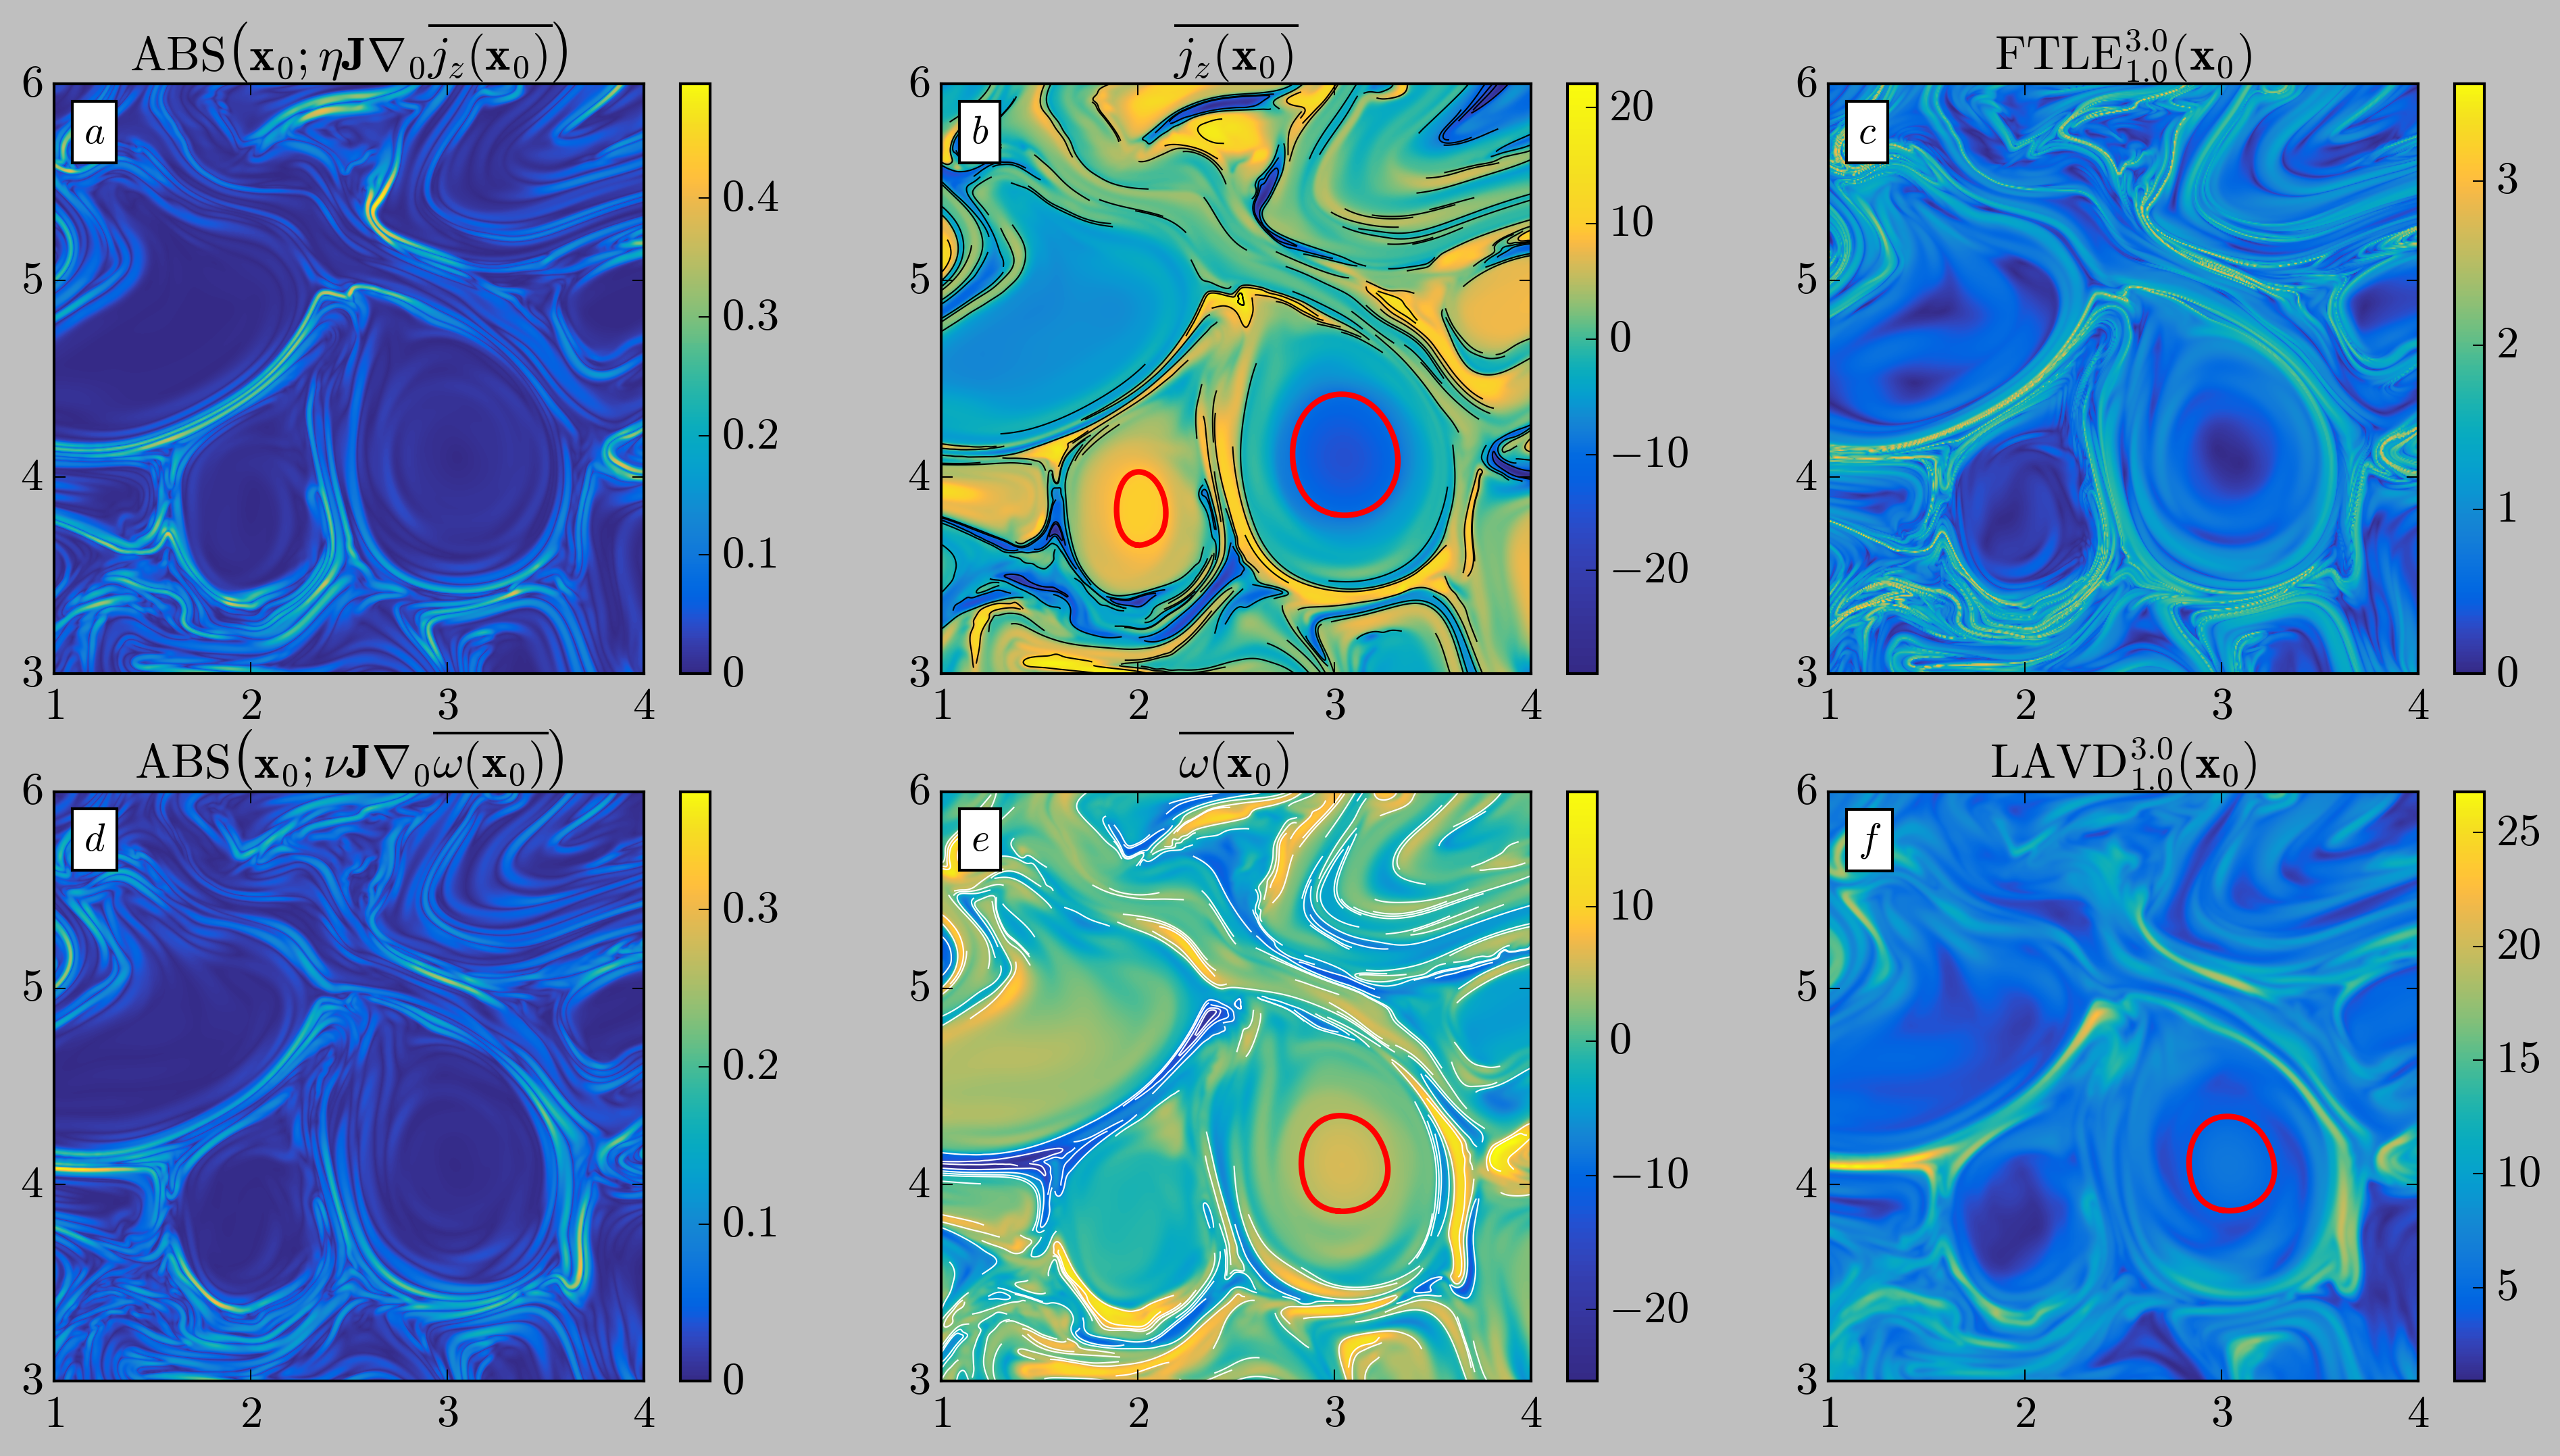

In [13]:
import matplotlib.colors as colors

fontsize = 18
cmap = cmapToUse

fig, ax = plt.subplots(2, 3, figsize = (16, 8), dpi = 300);

ax[0,0].set_title(r'$\mathrm{ABS}\left(\mathbf{x}_0; \eta \mathbf{J} \nabla_0 \overline{j_z(\mathbf{x}_0)} \right)$', fontsize = fontsize-1)
ax[1,0].set_title(r'$\mathrm{ABS}\left(\mathbf{x}_0; \nu \mathbf{J} \nabla_0 \overline{\omega(\mathbf{x}_0)} \right)$', fontsize = fontsize-1)

ax[0,1].set_title(r'$\overline{j_z(\mathbf{x}_0)}$', fontsize = fontsize-1)
ax[1,1].set_title(r'$\overline{\omega(\mathbf{x}_0)}$', fontsize = fontsize-1)

ax[0,2].set_title(r'$\mathrm{FTLE}_{1.0}^{3.0}(\mathbf{x}_0)$', fontsize = fontsize-1)
ax[1,2].set_title(r'$\mathrm{LAVD}_{1.0}^{3.0}(\mathbf{x}_0)$', fontsize = fontsize-1)

cax00 = ax[0,0].contourf(X, Y, eta*ABS_magnetic, cmap = cmapToUse, levels = 300)

cbar00 = fig.colorbar(cax00, ax = ax[0,0], ticks = [0, 0.1, 0.2, 0.3, 0.4])
cbar00.ax.set_yticklabels([r'$0$', r'$0.1$', r'$0.2$', r'$0.3$', r'$0.4$'], fontsize = fontsize - 2)

cax10 = ax[1,0].contourf(X, Y, nu*ABS_momentum, cmap = cmapToUse, levels = 400)
cbar10 = fig.colorbar(cax10, ax = ax[1,0], ticks = [0, 0.1, 0.2, 0.3])
cbar10.ax.set_yticklabels([r'$0$', r'$0.1$', r'$0.2$', r'$0.3$'], fontsize = fontsize - 2)

cax01 = ax[0,1].contourf(X, Y, jz_avg, levels = 400, cmap = cmapToUse, 
                         norm=colors.SymLogNorm(linthresh=10, linscale=1, base=10))
cbar01 = fig.colorbar(cax01, ax = ax[0,1], ticks = [-20, -10, 0, 10, 20])
cbar01.ax.set_yticklabels([r'$-20$', r'$-10$', r'$0$', r'$10$', r'$20$'], fontsize = fontsize-2)

for vortex in tqdm(vortices_magnetic):
    ax[0,1].plot(vortex[:,0], vortex[:,1], linestyle = "solid", linewidth = 2, c = "r")

for barrier in tqdm(barriers_magnetic):
    for b in barrier:
        ax[0,1].plot(b.y[0,:], b.y[1,:], c = "k", linewidth = 0.5)

cax11 = ax[1,1].contourf(X, Y, wz_avg, levels = 400, cmap = cmapToUse, 
                         norm=colors.SymLogNorm(linthresh=10, linscale=1, base=10))
cbar11 = fig.colorbar(cax11, ax = ax[1,1], ticks = [-20, -10, 0, 10])
cbar11.ax.set_yticklabels([r'$-20$', r'$-10$', r'$0$', r'$10$'], fontsize = fontsize-2)

for vortex in tqdm(vortices_momentum):
    ax[1,1].plot(vortex[:,0], vortex[:,1], linestyle = "solid", linewidth = 2, c = "r")

for barrier in tqdm(barriers_momentum):
    for b in barrier:
        ax[1,1].plot(b.y[0,:], b.y[1,:], c = "w", linewidth = 0.5)

cax02 = ax[0,2].contourf(X, Y, FTLE, levels = 400, cmap = cmapToUse)
cbar02 = fig.colorbar(cax02, ax = ax[0,2], ticks = [0, 1, 2, 3])
cbar02.ax.set_yticklabels([r'$0$', r'$1$', r'$2$', r'$3$'], fontsize = fontsize-2)

cax12 = ax[1,2].contourf(X, Y, LAVD, levels = 400, cmap = cmapToUse)
cbar12 = fig.colorbar(cax12, ax = ax[1,2], ticks = [0, 5, 10, 15, 20, 25])
cbar12.ax.set_yticklabels([r'$0$', r'$5$', r'$10$', r'$15$', r'$20$', r'$25$'], fontsize = fontsize-2)

for vortex in tqdm(vortices_LAVD):
    ax[1,2].plot(vortex[:,0], vortex[:,1], linestyle = "solid", linewidth = 2, c = "r")

ax[0,0].text(.05, .9, r'$a$', fontsize = fontsize-4, transform=ax[0,0].transAxes, bbox = dict(facecolor='w', edgecolor='k'))
ax[0,1].text(.05, .9, r'$b$', fontsize = fontsize-4, transform=ax[0,1].transAxes, bbox = dict(facecolor='w', edgecolor='k'))
ax[0,2].text(.05, .9, r'$c$', fontsize = fontsize-4, transform=ax[0,2].transAxes, bbox = dict(facecolor='w', edgecolor='k'))
ax[1,0].text(.05, .9, r'$d$', fontsize = fontsize-4, transform=ax[1,0].transAxes, bbox = dict(facecolor='w', edgecolor='k'))
ax[1,1].text(.05, .9, r'$e$', fontsize = fontsize-4, transform=ax[1,1].transAxes, bbox = dict(facecolor='w', edgecolor='k'))
ax[1,2].text(.05, .9, r'$f$', fontsize = fontsize-4, transform=ax[1,2].transAxes, bbox = dict(facecolor='w', edgecolor='k'))

for a in ax.ravel():
    
    a.set_xticks(xticks)
    a.set_yticks(yticks)
    
    a.set_xticklabels(xticklabels, fontsize = fontsize-2)
    a.set_yticklabels(yticklabels, fontsize = fontsize-2)
    
    a.set_xlim([xmin, xmax])
    a.set_ylim([ymin, ymax])
    a.set_aspect("equal")

plt.savefig(r'Fig4.jpg', bbox_inches = "tight", dpi = 500)
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

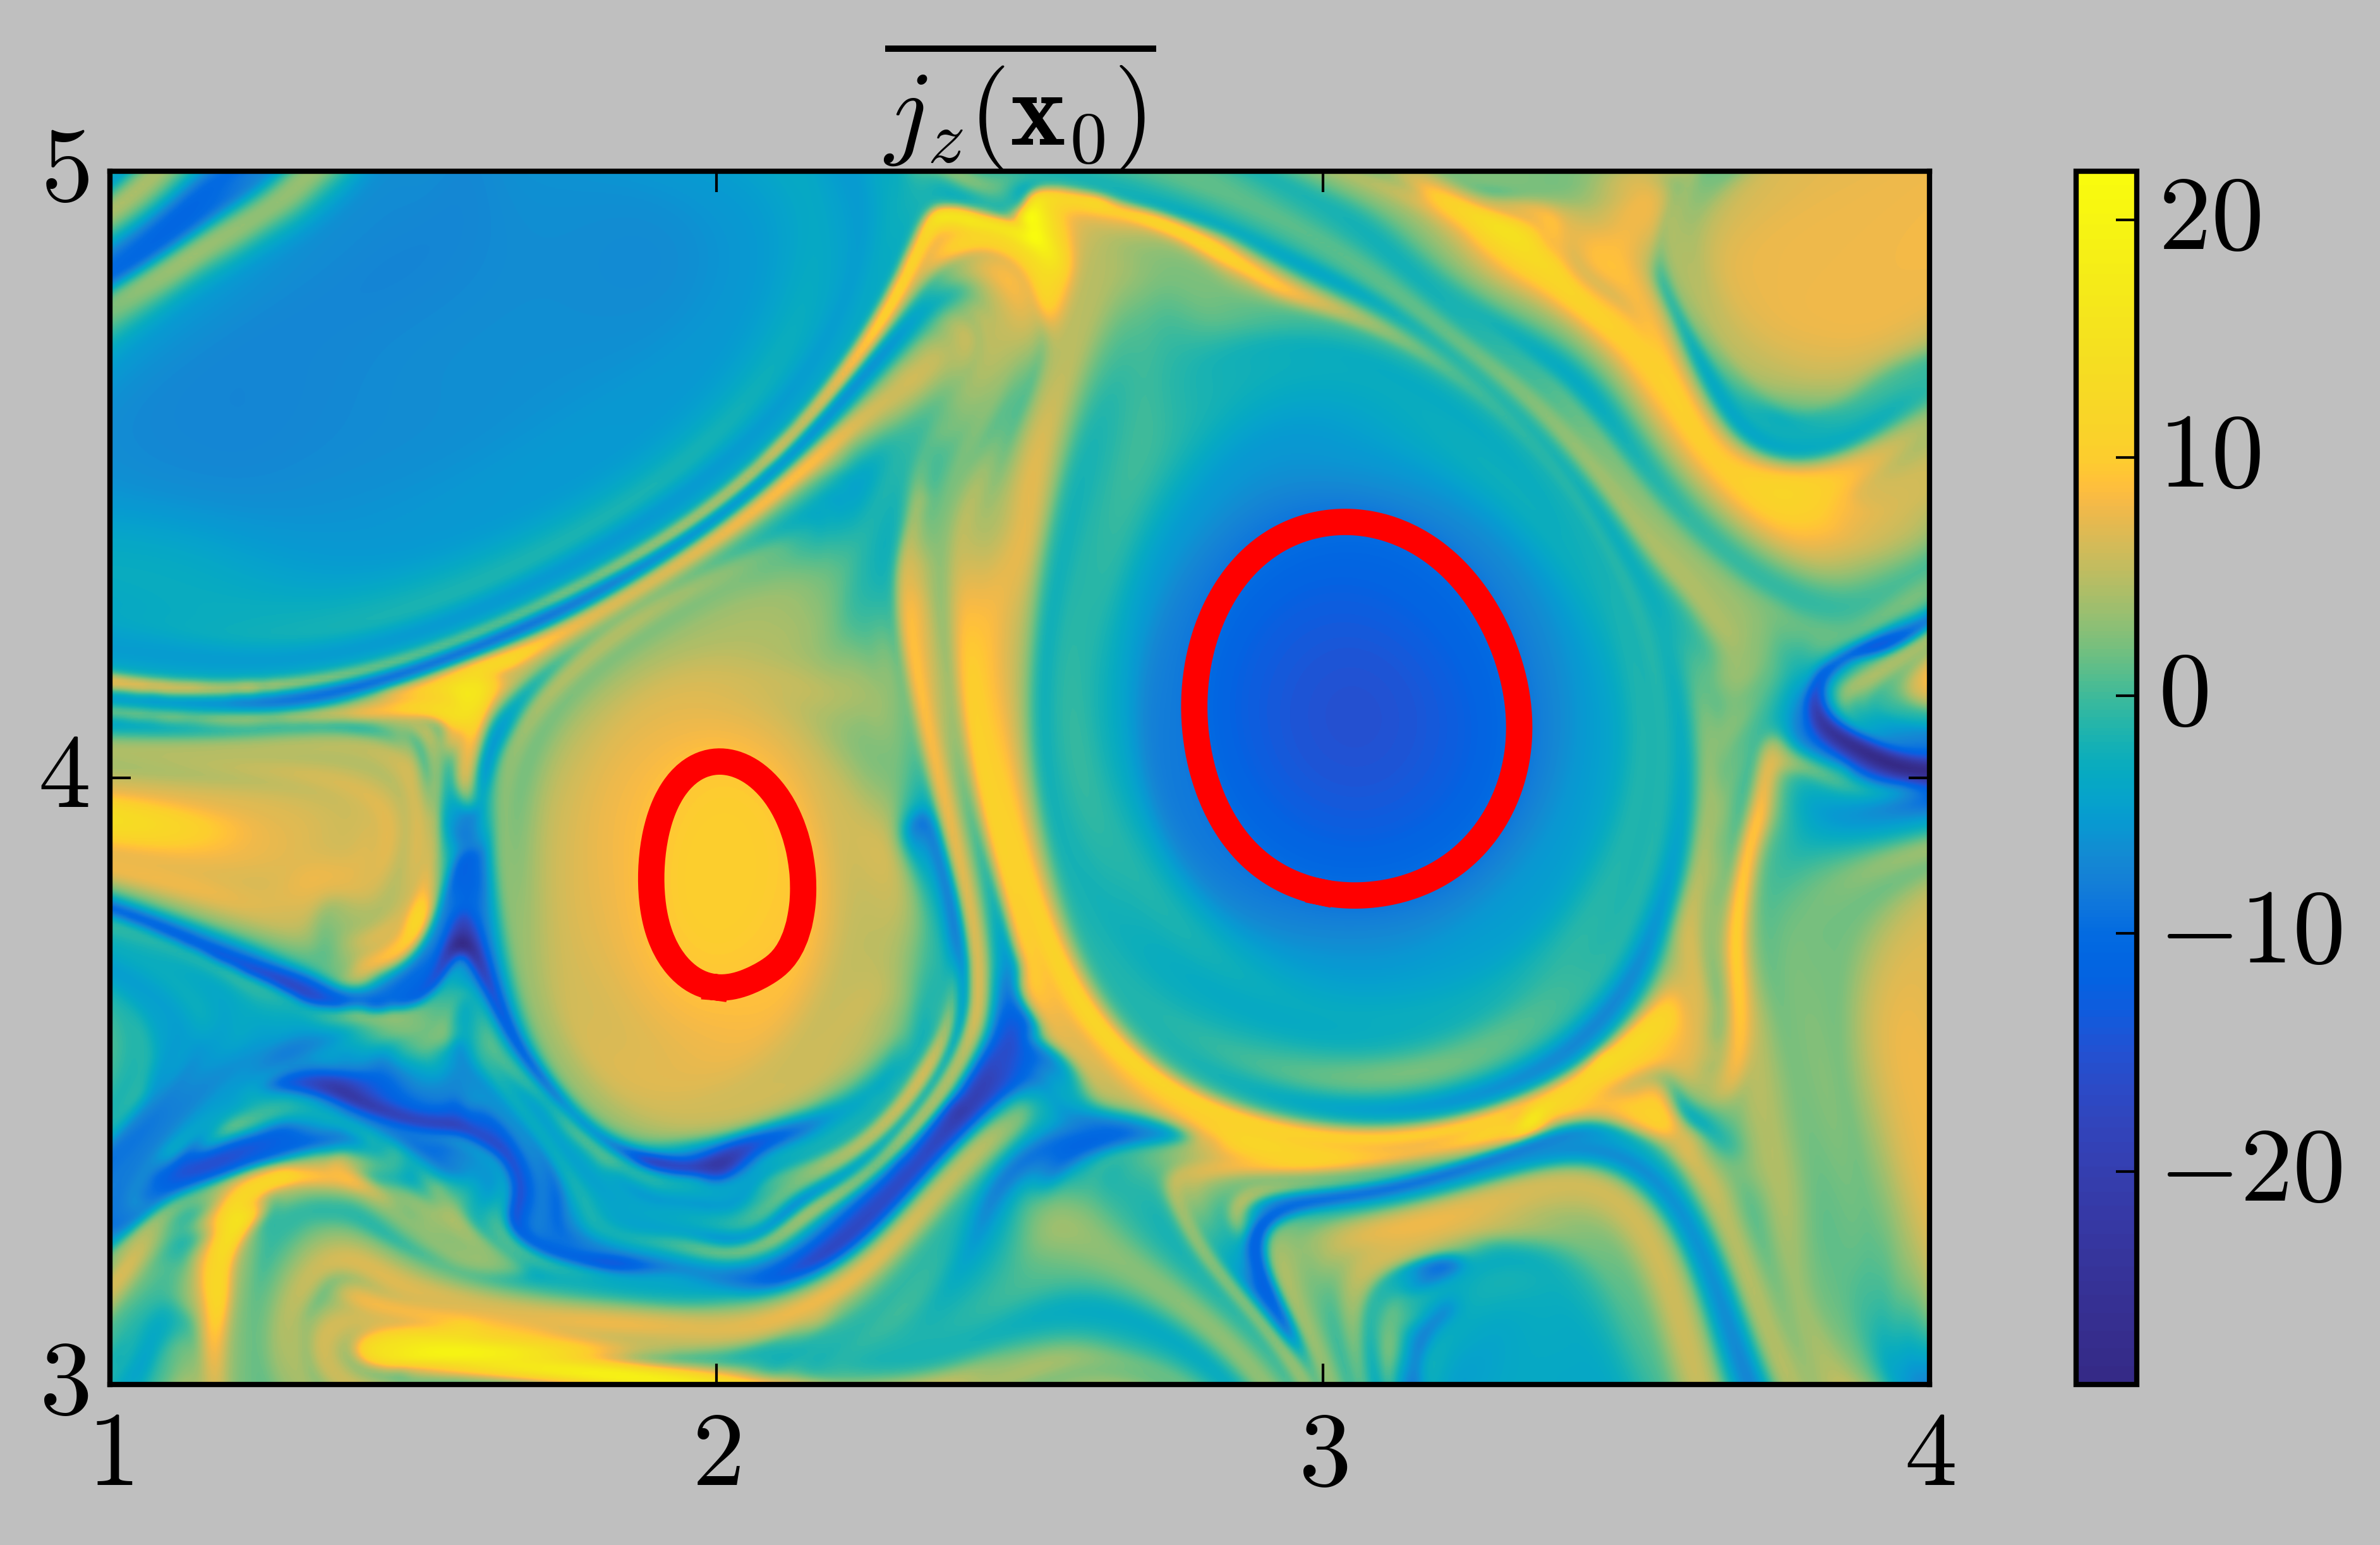

In [11]:
fontsize = 20

fig, ax = plt.subplots(1, 1, figsize = (10, 4), dpi = 600);

ax.set_title(r'$\overline{j_z(\mathbf{x}_0)}$', fontsize = fontsize)
cax = ax.contourf(X, Y, jz_avg, levels = 400, cmap = cmapToUse, 
                         norm=colors.SymLogNorm(linthresh=10, linscale=1, base=10))
cbar = fig.colorbar(cax, ax = ax, ticks = [-20, -10, 0, 10, 20])
cbar.ax.set_yticklabels([r'$-20$', r'$-10$', r'$0$', r'$10$', r'$20$'], fontsize = fontsize)

for vortex in tqdm(vortices_magnetic):
    ax.plot(vortex[:,0], vortex[:,1], linestyle = "solid", linewidth = 5, c = "r")

#for barrier in tqdm(barriers_magnetic):
#    for b in barrier:
#        ax.plot(b.y[0,:], b.y[1,:], c = "k", linewidth = 0.5)
        
ax.set_xticks(xticks)
ax.set_yticks(yticks)
    
ax.set_xticklabels(xticklabels, fontsize = fontsize)
ax.set_yticklabels(yticklabels, fontsize = fontsize)
    
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax-1])
ax.set_aspect("equal")
        
#ax.set_xlabel(r'$x$', fontsize = fontsize)
#ax.set_ylabel(r'$y$', fontsize = fontsize, rotation = 0)

plt.savefig(r'Fig_MHD_introduction_thesis.jpg', bbox_inches = "tight", dpi = 600)
plt.show()